**작성자** : 김종원, **작성일자** : 2022.02.25

# 축산 도매점을 운영하는 고객에게 비대면 온라인 소고기 판매 전략 방안

## 배경
축산 00 도매점을 운영하는 사장님이 가게 매출이 점점 떨어지고 있어서 네이버 스마트 스토어에 `소고기`라는 상품을 등록하여 판매를 하고자 한다. 하지만 사장님은 인터넷 상에서 판매를 하기 위해 상품을 등록하고 판매 전략이 미숙하다. 그래서 00 데이터 분석가에게 분석을 의뢰하였다.

<img src='https://user-images.githubusercontent.com/46054315/155854937-ff30a78a-2f1d-4372-9d85-4c0a8916d2e2.jpg' style="width:500px;height:300px">

# 1. 비즈니스 이해

## 1) 비즈니스 이해
00 축산 도매점을 운영하는 사장님이 코로나로 인해 비대면이 많아지면서 매출이 떨어지고 있다. 그래서 매출을 올리기 위해 비대면 온라인 판매를 통해 매출을 반등시키고자 하는데 상품을 등록하는 것과 판매 전략에 대해서 대면으로 파는 것은 강하지만 비대면 온라인 판매는 미숙하여 경쟁력있게 매출을 상승 시킬 판매 전략이 무엇인지 알고자 한다.

## 2) 비즈니스 목적
분석을 의뢰한 축산 도매점 사장님에게 네이버 스마트 스토어 상품 등록시 경쟁력 있게 상품을 판매하는 전략을 제시하여 이전보다 매출을 상승시킨다.

## 3) 분석 목표
네이버 검색어 API와 네이버 쇼핑 API를 통해 데이터를 수집하여 소고기 판매에 대한 적절한 판매 전략을 제시

---
# 2. 데이터 분석
## 1) 데이터 수집
1. 네이버 검색어 데이터 수집
    - 소고기 검색어 외 연관 검색어 수집
2. Naver Shop API를 활용해 상품 수 수집
    - 소고기와 연관 검색어에 대한 네이버 쇼핑에 상품 수 수집

### 1. 라이브러리 임포트

In [1]:
import pandas as pd
import signaturehelper

import os, re, time, random , json
import urllib
import requests

import warnings
import konlpy
from konlpy.tag import * 
from nltk import Text
from wordcloud import WordCloud

from tqdm import tqdm_notebook
import platform
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm

from matplotlib import font_manager, rc 
warnings.filterwarnings('ignore')

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system. sorry")

### 2. 네이버 검색어 데이터 수집
* API 사용 관련 기본 헤더 정보 및 환경 설정

In [2]:
# 네이버 검색어 API를 쓰기 위한 클라이언트 KEY 정보 및 헤더 정보 설정.
BASE_URL = 'https://api.naver.com'
API_KEY = "0100000000fb38c8744078c91d26e285bc1b9185ead3fa96abcf4dee84b9eabf8f23891af9"
SECRET_KEY = "AQAAAAD7OMh0QHjJHSbihbwbkYXqW6wx8KFferUMecPrfEkopg=="
CUSTOMER_ID = "2488471"

def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = signaturehelper.Signature.generate(timestamp, method, uri, SECRET_KEY)
    return {'Content-Type': 'application/json; charset=UTF-8', 'X-Timestamp': timestamp, 'X-API-KEY': API_KEY, 'X-Customer': str(CUSTOMER_ID), 'X-Signature': signature}


* Naver 검색어 API 호출
    - 소고기 검색

In [3]:
def keyword_master(keyword):
    """
        함수 설명 : 
            키워드를 파라미터로 받으면 해당 키워드에 대한 검색량과 연관 검색량에 대해서 수집 가능합니다.
        
        파라미터 설명:
            keyword : 검색 하고자 하는 키워드
            
        반환된 결과
            return : 검색한 키워드와 연관된 키워드들의 검색량 데이터 정보와 경쟁력 지수를 반환해줍니다.
    """
    
    # 키워드 관련 uri 정보
    # 참고 API 호출 설명서 : http://naver.github.io/searchad-apidoc/#/operations/GET/~2Fkeywordstool
    uri = '/keywordstool'
    method = 'GET'
    response = requests.get(f'{BASE_URL}{uri}?hintKeywords={keyword}&showDetail=1',
                     headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))
    
    # response를 받은 정보에서 keywordList 정보 추출하여 data 라는 변수에 저장합니다.
    data = response.json()['keywordList']
    # DataFrame을 만들기위해 사전 작업으로 사용될 컬럼 정보를 가져옵니다.
    columns_info = list(data[0].keys())
    
    # DataFrame을 만들기 전 데이터 정보를 dataset 이라는 리스트 변수에 차례대로 저장한다.
    dataset = []
    for i in  range(len(data)):
        blanck_list = []                 # data[n]번쨰에 있는 데이터 정보를 리스트 변수로 담기 위해 선언된 변수
        pick_data = data[i]              # 누구나 코드를 보았을때 변수에 대한 짐작이 가능하도록 가져올 데이터 정보를 pick_data 변수에 저장
        for col in columns_info:
            blanck_list.append(pick_data.get(col,"10"))  # 해당 정보가 없다면 10으로 반환
        dataset.append(blanck_list)

    return pd.DataFrame(dataset,columns=columns_info) # 반환된 데이터 형태를 DataFrame 형태로 반환.


In [4]:
keyword = "소고기"    # 검색할 키워드를 keyword 변수로 저장한다.
df = keyword_master(keyword)

In [5]:
df.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,monthlyAvePcClkCnt,monthlyAveMobileClkCnt,monthlyAvePcCtr,monthlyAveMobileCtr,plAvgDepth,compIdx
0,소고기,8900,88300,54.3,733.0,0.65,0.90,15,높음
1,한우,7780,60000,63.2,1024.3,0.89,1.88,15,높음
2,미국산소고기,1000,6060,14.7,126.3,1.56,2.26,15,높음
3,수입소고기,1250,7670,44.3,306.8,3.72,4.35,15,높음
4,스테이크,5380,49100,24.0,355.3,0.47,0.78,15,높음


### 3.검색어에 대한 NAVER 쇼핑에 등록된 상품의 수 정보 수집
* Naver 쇼핑 API 호출
    - 소고기와 연관 검색된 검색어 100개에 대한 Naver 쇼핑 상품 수 정보 수집 

In [6]:
def searchUrl(keyword, disp_num, start_num, sort_base):
    # 기본 url 정보
    base = "https://openapi.naver.com/v1/search/shop.json"
    
    param_query = "?query=" + urllib.parse.quote(keyword)   # 검색할 키워드 정보
    
    param_disp = "&display=" + str(disp_num)    # 검색 결과의 갯수
    param_start = "&start=" + str(start_num)    # 검색 결과의 문서의 시작점 위치
    param_sort = f"&sort={sort_base}"           # 검색 결과에 대한 정렬 옵션
    
    return base + param_query + param_start + param_disp + param_sort   # naver shop API를 호출할 url 정보

def getItemCount(url):
    naver_client_id = "HSUiWiCFSEgaskdkdddD"
    naver_client_secret = "2ZZyeZPMPC"
    
    # 네이버 API를 호출하기 위한 기본 클라이언트 ID와 비밀번호 정보 기입
    headers = {
                "X-Naver-Client-Id":naver_client_id,
                "X-Naver-Client-Secret": naver_client_secret,
    }
    # Naver shop API 호출
    response = requests.get(url,headers = headers)
    
    # 데이터를 불러오는데 약간의 delay가 될 수 있기에 혹시나의 불상사를 막기위해 sleep 0.2초를 주어 API호출을 시도하였다.
    time.sleep(0.2)
    item_count = response.json().get("total",0)
    return item_count

def item_count(keyword):
    """
        함수 설명 :
            검색량 키워드와 naver shop 제품의 수를 수집하여 DataFrame으로 변환해주는 함수.
        
        파라미터 :
            keyword : 검색할 키워드
            
        반환결과:
            return : 검색량 키워드와 naver shop 제품의 수가 수집된 DataFrame
    """
#     columns_info = ["relKeyword","monthlyPcQcCnt","monthlyMobileQcCnt"]
    df = keyword_master(keyword)
#     df = df[columns_info]
    
    # 100개의 데이터만 가져와서 분석을 진행합니다.
    df = df.head(100)

    search_Keywords = list(df["relKeyword"].values)  # Naver shop API에서 검색해야하는 keyword들
    data = []                                        # DataFrame을 만들기 위해 API에 호출된 데이터를 저장하는 변수
    # 키워드 포함하여 관련된 데이터 Naver API 호출
    for word in tqdm_notebook(search_Keywords):
        searching_url = searchUrl(word, 1, 10,"asc")   # API에 맞는 url 생성
        item_count = getItemCount(searching_url)       # 호출한 url에 대한 총 문서의 갯수
        data.append([word,item_count])                 # 뽑아온 데이터 정보를 저장.
    
    count_df = pd.DataFrame(data,columns = ["relKeyword","item_count"])  # 데이터 프레임으로 저장.
    df = pd.merge(df,count_df,on="relKeyword")                           # 검색량 키워드 데이터 프레임과 naver shop API에서 호출된 정보를 병합
    
    # 검색량이 10 이하 데이터는 10으로 데이터 정정.
    df.loc[df["monthlyPcQcCnt"]=="< 10","monthlyPcQcCnt"] = 10
    df.loc[df["monthlyMobileQcCnt"]=="< 10","monthlyMobileQcCnt"] = 10

    # 데이터 타입을 int형으로 변환
    df["monthlyPcQcCnt"] = df["monthlyPcQcCnt"].astype("int")
    df["monthlyMobileQcCnt"] = df["monthlyMobileQcCnt"].astype("int")

    df["total_search_count"] = df["monthlyPcQcCnt"] + df["monthlyMobileQcCnt"]  # 경쟁률이라는 컬럼을 생성한다.
    return df

In [7]:
result_df = item_count(keyword)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,monthlyAvePcClkCnt,monthlyAveMobileClkCnt,monthlyAvePcCtr,monthlyAveMobileCtr,plAvgDepth,compIdx,item_count,total_search_count
0,소고기,8900,88300,54.3,733.0,0.65,0.90,15,높음,998584,97200
1,한우,7780,60000,63.2,1024.3,0.89,1.88,15,높음,428397,67780
2,미국산소고기,1000,6060,14.7,126.3,1.56,2.26,15,높음,26760,7060
3,수입소고기,1250,7670,44.3,306.8,3.72,4.35,15,높음,75541,8920
4,스테이크,5380,49100,24.0,355.3,0.47,0.78,15,높음,801206,54480
...,...,...,...,...,...,...,...,...,...,...,...
95,구이용갈비,10,70,0.0,0.0,0.00,0.00,3,높음,7877,80
96,구이용살치살,10,20,0.0,0.7,0.00,3.04,3,높음,3104,30
97,구이용소갈비,10,200,0.2,0.0,3.71,0.00,5,중간,882,210
98,국거리소고기,190,2150,0.6,1.3,0.34,0.07,15,높음,49093,2340


## 2) 데이터 분석


* 소고기 검색어에 대한 경쟁률 분석

In [8]:
#  경쟁력 = 네이버 쇼핑 상품 수 / 검색량(모바일 + PC)
result_df["competition_rate"] = result_df["item_count"] / result_df["total_search_count"]
result_df = result_df[result_df["item_count"] !=0]
result_df = result_df.sort_values(by="competition_rate").reset_index(drop=True)
result_df[["relKeyword","total_search_count","item_count","competition_rate"]].head(50)

,relKeyword,total_search_count,item_count,competition_rate
0,마장동축산시장,31420,394,0.012540
1,아롱사태,23590,938,0.039763
2,한우스지,13320,806,0.060511
3,홍두깨살,18350,1880,0.102452
4,풀먹인소,700,73,0.104286
5,우둔살,14210,1594,0.112175
6,미국소고기등급,3040,430,0.141447
7,마장동한우선물세트,10020,1671,0.166766
8,소갈비살,18960,3240,0.170886
9,척아이롤,20480,3511,0.171436


### 1차 분석 결론

경쟁력이 높은 단어들의 특징들이 00 축산시장이라는 특징과 아롱사태, 한우 스지 등 소고기의 특수부위와 선물세트 대한 경쟁력이 높다고 판단된다. 하지만 위 특징들로 고객에게 판매전략을 제안하기에는 정보가 부족해 보인다.

---

In [9]:
# 데이터 저장.
result_df.to_csv(f"./keyword/{keyword}_데이터.csv",index=False,encoding="utf-8-sig")

* 소고기 검색어에 데이터 워드 클라우드

` 사람들이 소고기를 검색하면 연관해서 검색되는 단어는 무엇일까 ` 라는 생각으로 빈번한 **상품 키워드 분석**

In [10]:
def makeWorldCloud(df , column, stop_words=[],title=""):
    text = " ".join(df[column].values)
    # 형태소 분석
    okt = Okt()
    nouns = okt.nouns(text)
    nouns = [word for word in nouns if len(word) !=1]

    # 워드 클라우드 만들기
    # 명사의 갯수를 count 하는게 TEXT의 역할
    article = Text(nouns, name = "article")
    datas = article.vocab()
    words = dict(datas)
    wc = WordCloud(font_path = "D2Coding.ttf",background_color="white")

    # 불필요한 단어 제거
    stop_words = stop_words
    if len(stop_words) !=0:
        for stop_word in stop_words:
            del words[stop_word]

    plt.figure(figsize=(20, 8))
    plt.title(f"{title}에 대한 워드클라우드",fontsize= 30)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    plt.show()


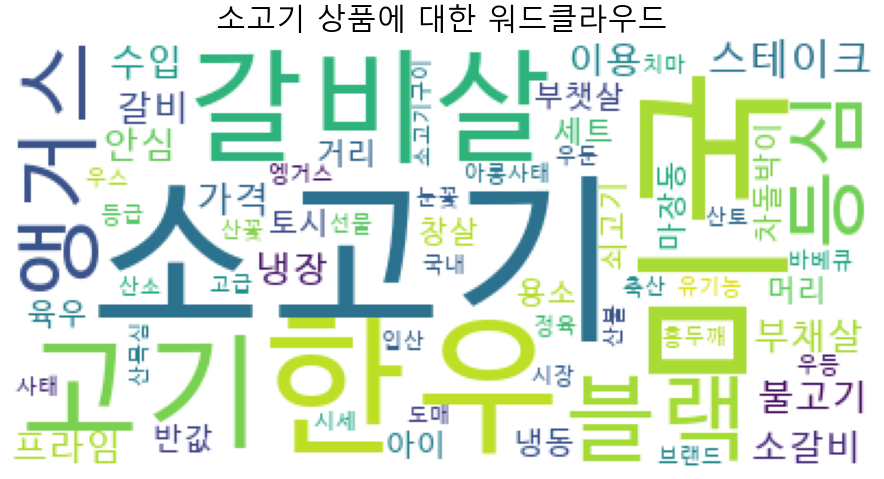

In [11]:
makeWorldCloud(result_df,'relKeyword',[],'소고기 상품')

**시각화 결과**
* 인기 있는 소고기 부위(갈비살, 안심, 등심, 부챗살... 등등)
* 미국산과 국내산 한우가 나뉘어 판매되고 있다.
* 냉장과 냉동도 나누어 판매가 되고 있다.
* 스테이크용 구이용 등 나뉘어 판매되고 있는데 이것은 요리에 따른 구매 이유가 다른 것으로 생각된다.

### 2차 분석 결론.
현재 축산 도매 고객에게 특수부위 외에도 갈비살, 안심, 등심, 부챗살 등 인기 부위를 같이 판매도 권유하고 싶은 점과 구이용 스테이크용 등 요리에 따라 소고기 부위를 판매하는 전략이 있으면 좋겠다. 그리고 현 분석을 의뢰한 고객이 우리나라에서 영농 한우 축산을 하시는 분이기에 국내산 한우를 판다는 가정하에 수입산과 국내산 한우에 대한 판매 전략이 구체적으로 작성할 필요가 있어 보이며 고객이 냉장육에 대해서 판매를 하고자 하니 소고기 냉장육에 대한 판매전략이 가능하도록 추가 분석이 필요하다

---

* 네이버 쇼핑 API에서 소고기냉장 키워드에 대한 상품 정보 수집

In [12]:
def getItem(url):
    """
        함수 설명 :
                API로 호출할 url 정보를 받아서 해당 검색 키워드에 해당하는 전체 문서의 수를 반환해주는 함수입니다.
        
        파라미터 : 
            url :API를 호출할 url 정보를 파라미터로 받는다.
        
        반환결과 :
            return API로 검색한 url에서 해당하는 상품 정보를 리턴 받는다.
    """
    import time
    naver_client_id = "HSUiWiCFSEgaskdkdddD"
    naver_client_secret = "2ZZyeZPMPC"
    
    # 네이버 API를 호출하기 위한 기본 클라이언트 ID와 비밀번호 정보 기입
    headers = {
                "X-Naver-Client-Id":naver_client_id,
                "X-Naver-Client-Secret": naver_client_secret,
    }
    # Naver shop API 호출
    response = requests.get(url,headers = headers)
    
    # 데이터를 불러오는데 약간의 delay가 될 수 있기에 혹시나의 불상사를 막기위해 sleep 0.2초를 주어 API호출을 시도하였다.
    time.sleep(0.2)
    item_count = response.json()
    return item_count

In [13]:
p = re.compile("\</{0,1}b\>")

# 크롤링된 정보를 담을 리스트 선언
beef_info = []
    
for k in range(2):
    url =  searchUrl(keyword = "소고기냉장", disp_num=100, start_num=1+(100*k), sort_base="sim") 
    one_result = getItem(url)
    for i in tqdm_notebook(range(100)):
        title = p.sub("",one_result["items"][i]["title"]) 
        price = int(p.sub("",one_result["items"][i]["lprice"]))
        mallName = one_result["items"][i]["mallName"]
        beef_info.append([title,mallName,price])
df = pd.DataFrame(beef_info,columns=["상품명","쇼핑몰","가격"])
df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,상품명,쇼핑몰,가격
0,숙성 와규 냉장 살치살 등심 부채살 갈비살 진갈비살 삼각살,미트아울렛,21900
1,하이마블 우대갈비 꽃갈비 미국산 냉장/냉동 초이스 비프립 소고기 홈파티 캠핑,하이마블,72000
2,당일도축 냉장 소고기 안심스테이크 원육 스테이크용소고기 150g 두께2.5cm스킨포장,솔직한농부,15500
3,[블랙비프] 소고기 등심 소갈비 살치살 부채살 우삼겹 차돌박이 냉장 구이용 와규 300g,신선마트 푸드장,9900
4,[쓱쓱맛나소] 냉장 소고기 살치살 갈비살 외 골라담기 블랙앵거스 프라임 등급 미국산,쓱쓱맛나소,15700


* 소고기 냉장육에 대한 데이터 분석

In [14]:
df.head(30)

,상품명,쇼핑몰,가격
0,숙성 와규 냉장 살치살 등심 부채살 갈비살 진갈비살 삼각살,미트아울렛,21900
1,하이마블 우대갈비 꽃갈비 미국산 냉장/냉동 초이스 비프립 소고기 홈파티 캠핑,하이마블,72000
2,당일도축 냉장 소고기 안심스테이크 원육 스테이크용소고기 150g 두께2.5cm스킨포장,솔직한농부,15500
3,[블랙비프] 소고기 등심 소갈비 살치살 부채살 우삼겹 차돌박이 냉장 구이용 와규 300g,신선마트 푸드장,9900
4,[쓱쓱맛나소] 냉장 소고기 살치살 갈비살 외 골라담기 블랙앵거스 프라임 등급 미국산,쓱쓱맛나소,15700
5,숙성 냉장 프라임급 살치살 워터에이징 등심 부채살 블랙앵거스급 립아이 채끝 안심 300g,미트아울렛,17900
6,마블플러스 호주산 안심 원육 냉장 이유식 비프웰링턴 캠핑 소고기 가정 홈파티용 스테이크,마블플러스 원,130000
7,숙성 냉장 블랙앵거스 초이스급 갈비살 토시살 살치살 갈비본살 원육,미트아울렛,33900
8,하이마블 냉장 아롱사태 원육 수비드 수육 찜 장조림 소고기,하이마블,19900
9,미국산 소갈비살 원육 냉장 1kg 늑간살 통갈비살,고가네육곳간,35420


상품명에 선물세트, 캠핑, 미국산, 국내산, 호주산 이라는 단어 확인된다.

1. 소고기 냉장육에 대한 선물세트 상품 비중

In [15]:
df.loc[df["상품명"].str.contains("선물"),"선물"] = 1
df.loc[~df["상품명"].str.contains("선물"),"선물"] = 0

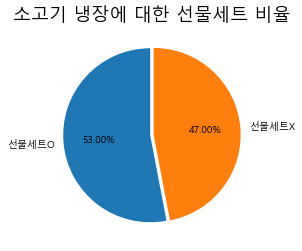

In [16]:
plt.title("소고기 냉장에 대한 선물세트 비율",size= 18)
table = df["선물"].value_counts()
plt.pie(table.values,
    labels=["선물세트O","선물세트X"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02])

plt.show()

소고기 냉장을 판매한다면 절반 이상이 선물세트로 판매한다.그럼 그안에서 수입산과 국내산을 비교를 한다면... 어떻게 될까?

2. 수입산과 국내산을 상품 비중

In [17]:
df.loc[df["상품명"].str.contains("미국산|호주산"),"원산지"] = "수입산"
df.loc[~df["상품명"].str.contains("미국산|호주산"),"원산지"] = "국내산"

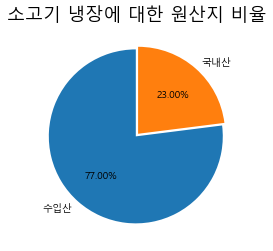

In [18]:
plt.title("소고기 냉장에 대한 원산지 비율",size= 18)
table = df["원산지"].value_counts()
plt.pie(table.values,
    labels=["수입산","국내산"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02])

plt.show()

대부분 네이버 쇼핑에서 수입산이 77 퍼센트를 차지한다. 국내산의 비중이 23 퍼센트로 작다.

3. 캠핑 또는 홈파티용으로 판매하는 상품의 비중

In [19]:
df.loc[df["상품명"].str.contains("캠핑|홈파티"),"캠핑"] = "캠핑|홈파티O"
df.loc[~df["상품명"].str.contains("캠핑|홈파티"),"캠핑"] = "캠핑|홈파티X"

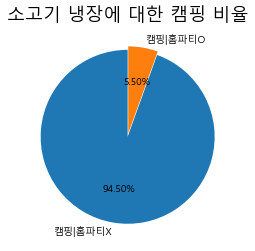

In [20]:
plt.title("소고기 냉장에 대한 캠핑 비율",size= 18)
table = df["캠핑"].value_counts()
plt.pie(table.values,
    labels=["캠핑|홈파티X","캠핑|홈파티O"],
    autopct = '%.2f%%',startangle=90,explode = [0.02, 0.02])

plt.show()

캠핑 또는 홈파티용으로 판매하는 비중이 약 5.5%로 매우 낮은 것으로 알 수 있다.

4. 원산지별 선물세트 상품 비중

소고기 냉장에 대한 선물세트 만족도 : 0.53


원산지,국내산,수입산
선물,,
0.0,0.978261,0.318182
1.0,0.021739,0.681818


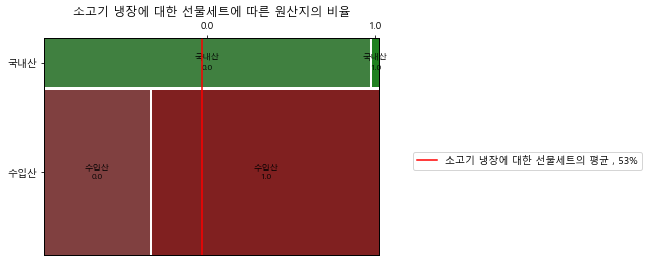

In [21]:
# 선물 세트의 비중
m = df["선물"].mean()

table = pd.crosstab(df["선물"],df["원산지"], normalize="columns")
print(f"소고기 냉장에 대한 선물세트 만족도 : {m}")
display(table)

mosaic(df.sort_values(['원산지','선물'],
       ascending=[False,True]), 
       ['원산지','선물'],
       gap=0.01,
       title='소고기 냉장에 대한 선물세트에 따른 원산지의 비율',
       horizontal=False , 
       axes_label=True
      )
plt.axvline(1- df['선물'].mean(), color = 'r')

plt.legend([f"소고기 냉장에 대한 선물세트의 평균 , {df['선물'].mean() * 100:.0f}%"], bbox_to_anchor=(1.8, 0.5))
plt.show()

현재 네이버 쇼핑에 소고기 냉장이 수입산 선물세트 비중이 높지만 국내산의 경우 매우 작고 별로 없는 것을 알 수 있다.

### 3차 분석 결론

현재 고객에게 국내산 한우 냉장육을 판매할때 선물 세트를 만들어서 판매를 한다면 경쟁력이 있다고 판매전략으로 제시하고 싶고, 위에서 단변량 분석때 캠핑|홈파티용 선물세트를 만들어서 판매하는 전략을 제시한다면 매출 상승에 좋은 요인이 될 것으로 판단된다.

**추가분석**

그러면 선물세트의 가격은 어떻게 결정해야 할까? 현 소고기 냉장 상품의 선물세트가 수입산 상품이 많기에 해외 상품에 대한 평균 가격을 파악하고 그에 맞게 세트 가격을 결정하는데 도움을 주자.

5. 수입산 상품에 대한 소고기 냉장육의 가격대 분포

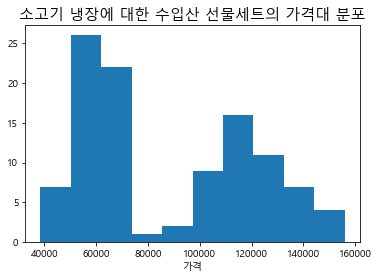

In [22]:
plt.hist(df.loc[(df["상품명"].str.contains("선물")) & (df["원산지"].str.contains("수입산"))]["가격"])
plt.title("소고기 냉장에 대한 수입산 선물세트의 가격대 분포",fontsize=15)
plt.xlabel("가격")
plt.show()

시각화 결과 해외 선물세트에 대한 가격대 분포가 쌍봉인 것을 알 수 있다. 해석을 해보았을때, 두 가지의 데이터 특징이 존재한다는 것을 알 수 있다. 그렇기에 7만원 기준으로 데이터를 구분하여 분석한다면 의미있는 정보가 도출될 것으로 생각된다.

6. 수입산 7 만원 이하 vs 7 만원 이상 제품의 특징

In [23]:
df_in = df.loc[(df["상품명"].str.contains("선물")) & (df["원산지"].str.contains("수입산"))]

df_price7_under = df_in[df_in["가격"] < 70000]
df_price7_over = df_in[df_in["가격"] >= 70000]

In [24]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [25]:
display_side_by_side(df_price7_under[["상품명"]].head(30),df_price7_over[["상품명"]].head(30), titles=['7만원 이하','7만원 이상'])

,상품명
15,"트러플 냉장와규(등심, 살치살, 새우살) 600g 소고기세트 트러플소스 호주산 와규 선물"
98,선물용 소고기 냉장 미국산 살치살 갈비살 선물 1kg
99,선물용 소고기 냉장 미국산 토시살 갈비살 선물 1kg
100,선물용 소고기 냉장 호주산 불고기500g 국거리 500g
101,선물용 소고기 냉장 미국산 부채살 살치살 선물 1kg
102,선물용 소고기 냉장 미국산 부채살 갈비살 선물 1kg
103,선물용 소고기 냉장 미국산 살치살 토시살 선물 1kg
105,선물용 소고기 냉장 미국산 부채살 토시살 선물 1kg
110,선물용 소고기 냉장 호주산 불고기500g 국거리 500g
112,선물용 소고기 냉장 미국산 부채살 살치살 선물 1kg


상품명에서 7만원 이하는 1kg 대를 판매하는 것으로 보이며, 7만원 이상은 2kg 이상의 상품을 판매하는 것을 알 수 있다.

In [26]:
# kg 추출.
def rmas(x):
    p = re.compile("[0-9]kg")
    try:
        tx = p.findall(x)[0]
    except:
        tx = "표기없음"
    return tx

df_price7_under["kg"] = df_price7_under["상품명"].apply(lambda x: rmas(x))
df_price7_over["kg"] = df_price7_over["상품명"].apply(lambda x: rmas(x))

In [27]:
print("7만원대 이하 선물세트 평균 가격 : ",format(round(df_price7_under["가격"].mean()),","),"원")
print("7만원대 이상 선물세트 평균 가격 : ",format(round(df_price7_over["가격"].mean()),","),"원")

display_side_by_side(
    pd.DataFrame(df_price7_under["kg"].value_counts()),
    pd.DataFrame(df_price7_over["kg"].value_counts()),
    titles=['7만원 이하','7만원 이상'])

7만원대 이하 선물세트 평균 가격 :  57,223 원
7만원대 이상 선물세트 평균 가격 :  113,566 원


,kg
1kg,41
표기없음,6
,kg
2kg,49
1kg,9


### 4차 분석결론

네이버 쇼핑에서 소고기 냉장 수입산 선물세트가 1kg대는 약 5만 7천원으로 판매되고 있고, 2kg은 11만원으로 판매되고 있으니 해당 가격과 유사하게 판매를 한다면 이전 보다 매출이 상승될 것으로 판단된다.

7. 국내산과 수입산 소고기의 경쟁력
<img src="https://user-images.githubusercontent.com/46054315/155855000-954b438b-180a-403c-8ddc-327f9b6769f3.PNG">

전체적으로 보았을때 수입산과 국내산 경쟁력이 차이가 미미하기에 한우가 좋은 전략이 있다면 수입산을 압도할 것으로 생각된다.

8. 국내산과 수입산 상품에 대한 워드 클라우드

<img src = 'https://user-images.githubusercontent.com/46054315/155855034-ec7529e5-aa5d-4b22-a650-b315b27a0178.PNG'>

국산의 경우 '명절, 선물, 포장'과 같이 선물을 위한 단어들이 있는 반면 미국산은 본인이 먹기위해 구매하는 경우가 많아 보인다

### 5차 분석결과
한우를 선물하는 용도로 키워드를 작성하면 좋은 경쟁력을 보여줄 것으로 추정된다.

---

## 3. 분석 결론
### 1) 비즈니스 인사이트

1. 축산 도매점을 운영하는 고객에게 축산도매점이라는 특징과 경쟁력이 높은 특수부위 판매에 대한 판매 전략을 제시하고자 한다.


2. **`인기 있는 부위(갈비살, 안심, 등심 등)와 특수부위를 합쳐 선물세트 또는 캠핑|홈파티용 세트를 구성하여 판매하는 전략을 제시하고자 한다.`**


3. **`선물세트의 가격대를 결정하기 위해 소고기 국내산 냉장육 선물세트에 대한 네이버 상품이 수입산에 비해 상품 수가 적기에 수입산의 선물세트의 평균 가격대를 참고하여 비슷하게 형성하거나 앞전 인사이트 대로 부위를 합쳐서 특정 용도인 세트를 만들어서 판매를 한다면 영업 이익에 매출 상승이 되는 판매 전략이 될 것으로 추정된다.`**


4. 캠핑|홈파티용 외에도 다양한 소고기 요리 키트를 만들어서 판매를 한다면 구워 먹는 것 외에도 고객이 다양하게 소고기를 즐길 것으로 추정되어 소고기 요리 키트 세트라는 상품을 기획하여 여러 요리를 다양한 맛으로 즐겨 보세요 라는 1분 릴스를 제작하여 해당 상품의 관심을 유도해 판매를 유도한다면 영업 이익이 상승될 것으로 추정된다.  